In [139]:
from decouple import config
import os
import pandas as pd
from nilearn import datasets, plotting, image
from sklearn import linear_model
from fNeuro.utils.pickling import load_pickle 
from fNeuro.ml.ml_functions import estimate_regression_model
from fNeuro.connectivity.connectivity import get_correlation_long_df, get_mean_correlation_matrix
import seaborn as sns
sns.set_style('darkgrid')
import re
import numpy as np
import pandas as pd

In [138]:
#ml imports
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

In [147]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
group = np.asarray(list(time_series['an'].values()) + list(time_series['hc'].values()))


In [141]:
autistic_traits = pd.read_csv(os.path.join(resting_path, 'autistic_traits_neuroimaging.csv'))
autistic_traits['B_Number'] = autistic_traits['B_Number'].str.rstrip()
autistic_traits = autistic_traits.drop(autistic_traits[autistic_traits['B_Number'].str.contains('B2010')].index).reset_index(drop=True)
autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
participant_order = load_pickle(os.path.join(resting_path, 'measures', 'connectome_participant_order'))
order = [re.findall('B\d\d\d\d', participant)[0] for participant in participant_order]
connectome_dict = dict(zip(order, connectome))
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })


/tmp/ipykernel_73714/3537036702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'


In [148]:
correlation_matrix = get_mean_correlation_matrix(group, msdl['labels'])
an_df = get_correlation_long_df(correlation_matrix['an_mean_correlations'], msdl_overview_df)

TODO

Improve accuracy

In [4]:
aq_df = autistic_traits[['B_Number', 'aq10']].dropna().reset_index(drop=True)
y_aq = aq_df['aq10'].values
x_aq = np.array([connectome_dict.get(key) for key in aq_df['B_Number'].values])

<Axes: ylabel='Count'>

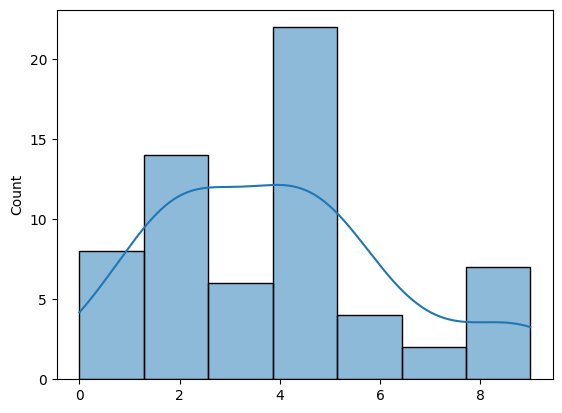

In [5]:
sns.histplot(data=y_aq, kde=True)

In [31]:
min_features_to_select = 1  # Minimum number of features to consider
models = {'lasso': linear_model.Lasso(), 
          'ridge': linear_model.Ridge(), 
          'ran': RandomForestRegressor(max_depth=3, random_state=0), 
          'svc': svm.SVR(kernel='linear', gamma="auto", C=0.01),
          'linear': linear_model.LinearRegression()
          }
cv = StratifiedKFold(5)

for model in models.keys():
    print('working on ',  model)

    rfecv = RFECV(
        estimator=models[model],
        step=1,
        cv=cv,
        scoring="r2",
        min_features_to_select=min_features_to_select,
        n_jobs=3,
    )
    rfecv.fit(x_aq, y_aq)
    print(model)
    print(f"Optimal number of features for {model}: ", rfecv.n_features_)
    print(f'Best mean r2 for {model}: ', rfecv.cv_results_['mean_test_score'].max())

working on  lasso


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


lasso
Optimal number of features for lasso:  1
Best mean r2 for lasso:  -0.1961176876329733
working on  ridge


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ridge
Optimal number of features for ridge:  183
Best mean r2 for ridge:  -0.29076955927955134
working on  ran


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ran
Optimal number of features for ran:  11
Best mean r2 for ran:  0.1757681158745247
working on  svc


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


svc
Optimal number of features for svc:  1
Best mean r2 for svc:  -0.2609840225068139


In [149]:
from sklearn.feature_selection import r_regression
test = r_regression(x_aq, y_aq)
index = np.where((test > 0.1) | (test < -0.1))[0]
x = x_aq[0:, index]
an_df = an_df.iloc[index]

In [108]:
lasso = linear_model.LassoCV(cv=10, n_jobs=3)
scores_lasso = estimate_regression_model(lasso, x, y_aq)
print('R2: ', scores_lasso['r2'].mean())
print('MAE: ', scores_lasso['MAE'].mean())
print('MSE: ', scores_lasso['MSE'].mean())

R2:  -0.07360712884466067
MAE:  -2.088226657488294
MSE:  -6.661414328771843


In [109]:
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
scores_ridge = estimate_regression_model(ridge, x, y_aq)
print('R2: ', scores_ridge['r2'].mean())
print('MAE: ', scores_ridge['MAE'].mean())
print('MSE: ', scores_ridge['MSE'].mean())

R2:  0.3263828720499099
MAE:  -1.578087687629402
MSE:  -4.169635627756922


In [105]:
svc_parameters = {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
svm_regression = GridSearchCV(svm.SVR(kernel='linear', gamma="auto"), svc_parameters)
scores_svm = estimate_regression_model(svm_regression, x, y_aq)
print('R2: ', scores_svm['r2'].mean())
print('MAE: ', scores_svm['MAE'].mean())
print('MSE: ', scores_svm['MSE'].mean())

R2:  0.33082814807615496
MAE:  -1.5748808284525329
MSE:  -4.142859800675713


In [106]:
tree_parm = {'max_depth':[3, 5, 7]}
ran_forest = GridSearchCV(RandomForestRegressor(random_state=0), tree_parm)
score_ran = estimate_regression_model(ran_forest, x, y_aq)
print('R2: ', score_ran['r2'].mean())
print('MAE: ', score_ran['MAE'].mean())
print('MSE: ', score_ran['MSE'].mean())

R2:  0.10258373789378583
MAE:  -1.9906960863227325
MSE:  -5.570562437215904


In [107]:
bagged_model = BaggingRegressor(svm_regression, n_estimators=50, n_jobs=2)
bagged_scores = estimate_regression_model(bagged_model, x, y_aq)
print('R2: ', bagged_scores['r2'].mean())
print('MAE: ', bagged_scores['MAE'].mean())
print('MSE: ', bagged_scores['MSE'].mean())

R2:  0.3462231600841076
MAE:  -1.5974607105673642
MSE:  -3.930389625648774


In [113]:
estimators = [('ridge',linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])), ('svr', svm.SVR(kernel='linear', gamma="auto"))]
stacked_estimator = StackingRegressor(estimators)
stacked_estimator_model = estimate_regression_model(stacked_estimator, x, y_aq)
print('R2: ', stacked_estimator_model['r2'].mean())
print('MAE: ', stacked_estimator_model['MAE'].mean())
print('MSE: ', stacked_estimator_model['MSE'].mean())

R2:  0.3091507651547773
MAE:  -1.6343381264744192
MSE:  -4.279206894790424


In [129]:
comp_score_dict = {'r2': pd.DataFrame(data={
                                            'lasso': scores_lasso['r2'],
                                            'ridge': scores_ridge['r2'],
                                            'random_forest': score_ran['r2'],
                                            'svr': scores_svm['r2'],
                                            'bagged': bagged_scores['r2'],
                                            'stacked': stacked_estimator_model['r2'],
                                                }),
                'MAE': pd.DataFrame(data={
                                            'lasso': scores_lasso['MAE'],
                                            'ridge': scores_ridge['MAE'],
                                            'random_forest': score_ran['MAE'],
                                            'svr': scores_svm['MAE'],
                                            'bagged': bagged_scores['MAE'],
                                            'stacked': stacked_estimator_model['MAE'],
                                                }),
                'MSE': pd.DataFrame(data={
                                            'lasso': scores_lasso['MSE'],
                                            'ridge': scores_ridge['MSE'],
                                            'random_forest': score_ran['MSE'],
                                            'svr': scores_svm['MSE'],
                                            'bagged': bagged_scores['MSE'],
                                            'stacked': stacked_estimator_model['MSE'],
                                                })
}


<Axes: xlabel='r2', ylabel='Model'>

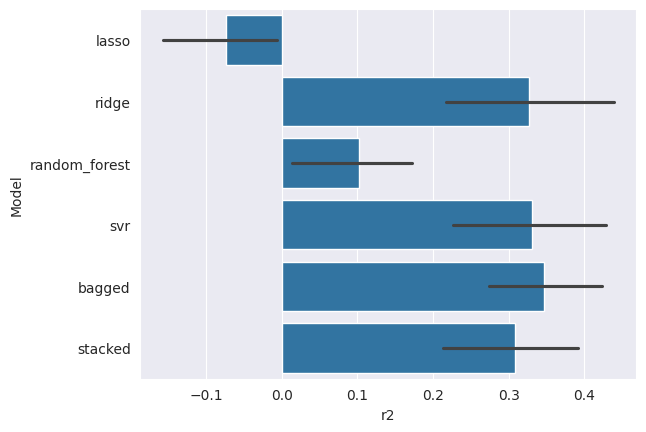

In [133]:
sns.barplot(data=pd.melt(comp_score_dict['r2']).rename(columns={'variable': 'Model', 'value': 'r2'}), 
                   x='r2', y='Model')

<Axes: xlabel='Negative Mean Absolute Error', ylabel='Model'>

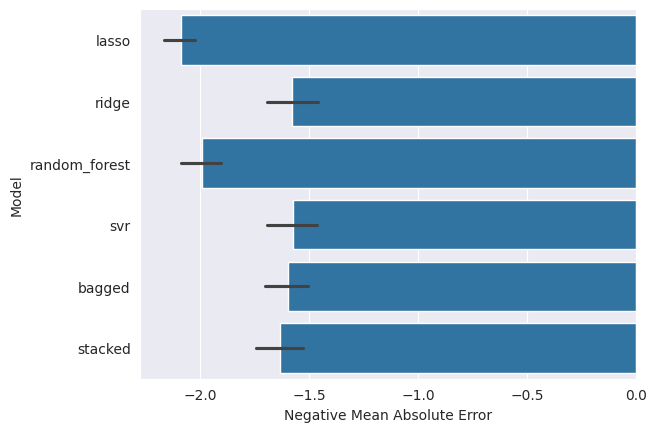

In [136]:
sns.barplot(data=pd.melt(comp_score_dict['MAE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Absolute Error'}), 
                   x='Negative Mean Absolute Error', y='Model')

<Axes: xlabel='Negative Mean Squared Error', ylabel='Model'>

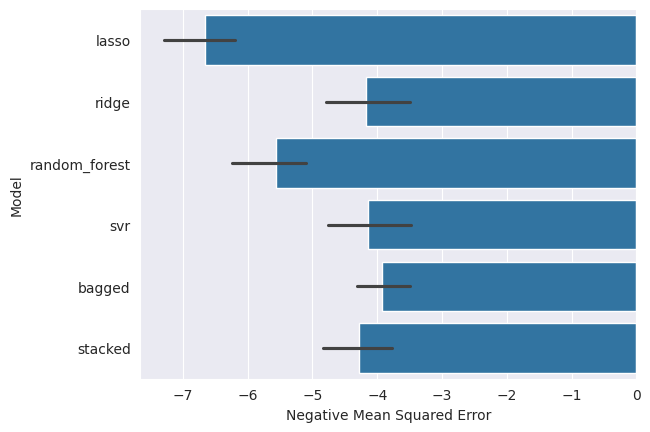

In [137]:
sns.barplot(data=pd.melt(comp_score_dict['MSE']).rename(columns={'variable': 'Model', 'value': 'Negative Mean Squared Error'}), 
                   x='Negative Mean Squared Error', y='Model')

In [151]:
an_df['svr_values'] = bagged_model.estimator_.best_estimator_.coef_.T

In [165]:
an_df

,corr_names,correlation,network_names,svr_values
5,Striate - L DMN,-2.378428,Striate - DMN,-0.003066
6,L Aud - Med DMN,2.629387,Aud - DMN,0.000949
7,R Aud - Med DMN,2.301681,Aud - DMN,-0.003150
8,Striate - Med DMN,-3.954418,Striate - DMN,-0.002976
9,L DMN - Med DMN,-1.002768,DMN - DMN,-0.000536
...,...,...,...,...
731,Broca - R Ant IPS,3.049106,Language - Ant IPS,-0.006868
732,Sup Front S - R Ant IPS,1.345453,Language - Ant IPS,-0.000484
735,Cereb - R Ant IPS,-0.965142,Cereb - Ant IPS,-0.000754
736,Dors PCC - R Ant IPS,2.681498,Dors PCC - Ant IPS,-0.007447


In [168]:
network_values = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for network in network_values.keys():
    network_df = an_df[an_df['network_names'].str.startswith(network)]
    within_network_df = network_df[network_df['network_names'] == f'{network} - {network}'] 
    between_network_df = network_df.drop(within_network_df.index).reset_index(drop=True) 
    network_values[network]['within'] = within_network_df
    network_values[network]['between'] = between_network_df

In [176]:
for network in network_values.keys():
    print(network, len(network_values[network]['within']))

Aud 0
Striate 0
DMN 4
Occ post 0
Motor 0
R V Att 3
Basal 0
L V Att 2
D Att 1
Vis Sec 0
Salience 2
Temporal 0
Language 3
Cereb 0
Dors PCC 0
Cing-Ins 0
Ant IPS 1


In [159]:
sort_an_df = an_df.sort_values(by='svr_values',key=abs, ascending=False).reset_index(drop=True)

In [163]:
sort_an_df.iloc[0]

corr_names       R Aud - L IPS
correlation          -3.592281
network_names      Aud - D Att
svr_values            0.009736
Name: 0, dtype: object